# Convolutional Autoencoder

The notebook shows how simple autoencoder types can be designed with Knet and NNHelferlein.    
The small example images are in the NNHelderlein data-directory.

In [1]:
using Knet
using NNHelferlein
using Images

### Data
Load images from directory, flatten the 64x64x3 tensors to a 1-D-vecor and
build a matrix with 12288 rows (= RGB-values of all pixels) and 
4 columns (= number of pictures).   

Training data must be flattened because each image is represented by a 1D-vector 
in the perceptron.    
Final training tensor is (num-pixels x 3) x (num images):

,,,,

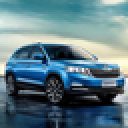
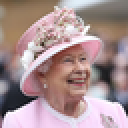
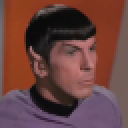
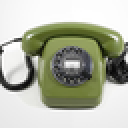
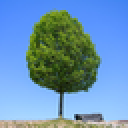

In [2]:
d = joinpath(NNHelferlein.DATA_DIR, "Images64")
imgs = [load(joinpath(d, i)) for i in readdir(d) if occursin("png", i)]

## The Autoencoder

For the convolutional autoencoder the decoder output is 
cropped to the original image size before loss calculation.

In [3]:
struct CnnAE <: DNN
    layers
    CnnAE(e,d) = new([e,d])
end

function (ae::CnnAE)(x)
    
    # encode:
    #
    size_in = size(x)
    x = ae.layers[1](x)
    
    # decode:
    #
    x = ae.layers[2](x)
    x = crop_array(x, size_in)
    return x
end

# square loss:
#
(ae::CnnAE)(x, y) = sum(abs2, ae(x) .- y)

In [4]:
encoder = Chain(
            Conv(5,5,3,32; padding=2),
            Pool(),
            Conv(5,5,32,16; padding=2),
            Pool(),
            Conv(5,5,16,8; padding=2),
            Pool())

decoder = Chain(
            DeConv(5,5,8,16; stride=2),
            DeConv(5,5,16,32; stride=2),
            DeConv(5,5,32,3; stride=2))

Chain((DeConv(P(KnetArray{Float32, 4}(5,5,16,8)), P(KnetArray{Float32, 4}(1,1,16,1)), Knet.Ops20.relu, Base.Pairs(:stride => 2)), DeConv(P(KnetArray{Float32, 4}(5,5,32,16)), P(KnetArray{Float32, 4}(1,1,32,1)), Knet.Ops20.relu, Base.Pairs(:stride => 2)), DeConv(P(KnetArray{Float32, 4}(5,5,3,32)), P(KnetArray{Float32, 4}(1,1,3,1)), Knet.Ops20.relu, Base.Pairs(:stride => 2))))

In [5]:
cae = CnnAE(encoder, decoder)
print_network(cae)

Neural network summary:
CnnAE with 2 layers,                                             36907 params
Details:
 
    Chain with 6 layers,                                         18456 params
 
        Conv layer 3 → 32 (5,5) [:padding => 2] with relu,        2432 params
        Pool layer,                                                  0 params
        Conv layer 32 → 16 (5,5) [:padding => 2] with relu,      12816 params
        Pool layer,                                                  0 params
        Conv layer 16 → 8 (5,5) [:padding => 2] with relu,        3208 params
        Pool layer,                                                  0 params
 
    Chain with 3 layers,                                         18451 params
 
        DeConv layer 8 → 16 (5,5) [:stride => 2] with relu,       3216 params
        DeConv layer 16 → 32 (5,5) [:stride => 2] with relu,      12832 params
        DeConv layer 32 → 3 (5,5) [:stride => 2] with relu,       2403 params
 
 
Total number of la

9

Training data must be provided as 4D-array for the CNN (image hight, image width, rgb, num images):

In [6]:
trn = cat((image2array.(imgs))..., dims=4)
trn = convert2KnetArray(trn)
size(trn)

(64, 64, 3, 5)

In [7]:
@show y = size(cae(trn))
@show loss = cae(trn, trn)

y = size(cae(trn)) = (64, 64, 3, 5)
loss = cae(trn, trn) = 21514.627f0


21514.627f0

Minibatches and train until the images are reconstructed:

In [8]:
mbs = minibatch(trn, trn, 5)

1-element Knet.Train20.Data{Tuple{KnetArray{Float32}, KnetArray{Float32}}}

In [12]:
tb_train!(cae, Adam, mbs, epochs=10000, lr=0.0001)

Training 10000 epochs with 1 minibatches/epoch
Evaluation is performed every 1 minibatches (with 1 mbs).
Watch the progress with TensorBoard at: /home/andreas/.julia/dev/NNHelferlein/examples/logs/run/2021-12-20T10-38-20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


Training finished with:
Training loss:       57.801429748535156


CnnAE(Chain[Chain((Conv(P(KnetArray{Float32, 4}(5,5,3,32)), P(KnetArray{Float32, 4}(1,1,32,1)), Knet.Ops20.relu, Base.Pairs(:padding => 2)), Pool(Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}()), Conv(P(KnetArray{Float32, 4}(5,5,32,16)), P(KnetArray{Float32, 4}(1,1,16,1)), Knet.Ops20.relu, Base.Pairs(:padding => 2)), Pool(Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}()), Conv(P(KnetArray{Float32, 4}(5,5,16,8)), P(KnetArray{Float32, 4}(1,1,8,1)), Knet.Ops20.relu, Base.Pairs(:padding => 2)), Pool(Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}()))), Chain((DeConv(P(KnetArray{Float32, 4}(5,5,16,8)), P(KnetArray{Float32, 4}(1,1,16,1)), Knet.Ops20.relu, Base.Pairs(:stride => 2)), DeConv(P(KnetArray{Float32, 4}(5,5,32,16)), P(KnetArray{Float32, 4}(1,1,32,1)), Knet.Ops20.relu, Base.Pairs(:stride => 2)), DeConv(P(KnetArray{Float32, 4}(5,5,3,32)), P(KnetArray{Float32, 4}(1,1,3,1)), Knet.Ops20.relu, Base.Pairs(:stride => 2))))])

,,,,

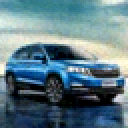
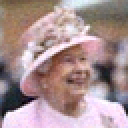
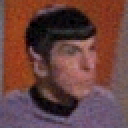
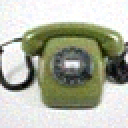
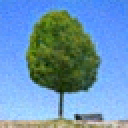

In [13]:
y = cae(trn)
[array2image(y[:,:,:,i]) for i in 1:size(y)[end]]